### Imports

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
import IPython.display as pyDisplay
import matplotlib.transforms as transforms
import scipy.special as sciSpec
import subprocess
import tfs

from cpymad.madx import Madx

#import xline as xl
#import xobjects as xo
#import xtrack as xt
#import xpart as xp

# Utilities

In [95]:

##############################################################
def vecNorm(vec):
    return np.sqrt(vec[0]**2 + vec[1]**2)
##############################################################


##############################################################
def getMultiCoeff(I,L,pos,nmax=1):
    # To be redefined from cst list
    mu0 = 4e-7*np.pi 
    
    # compute the integrated normal and skew components
    # Note: mistake in Axel's thesis, the n! not consistent with definition of fields
    # Note: mistake in Axel's thesis, sign of integrated component not correct. Refer to S.F. paper.
    n = np.arange(nmax+1)
    integratedComp = -mu0*(I*L)*sciSpec.factorial(n)/(2*np.pi)/(pos[0]+1j*pos[1])**(n+1)
    
    kn,sn = np.real(integratedComp),np.imag(integratedComp)
    
    return kn,sn
##############################################################


##############################################################
def makeMadWire(I,L,pos,p0c,at = 0,nmax=20,mask=None,name = 'multipole_wire'):
    
    kn,sn = getMultiCoeff(I,L,pos,nmax=nmax)
    
    # To be redefined from cst list
    c = 299792458 
    
    # mask -> boolean array used to choose only specific orders of the multipole expansion
    if mask is not None:
        kn[np.invert(mask)] = 0
        sn[np.invert(mask)] = 0
        
    # p0 -> momentum in eV/c
    KNL = (kn/(p0c/c))
    KSL = (sn/(p0c/c))
    
    # computing HKICK and VKICK from dipole component:
    #-----------------------------------
    # complexKicks =  DPx - iDPy
    complexKick = -(KNL[0] + 1j*KSL[0])
    HKICK,VKICK = np.real(complexKick),-np.imag(complexKick)
    #-----------------------------------

    
    def_1of2 = f'class_{name}_1of2 : MULTIPOLE,KNL = {{0,{",".join(KNL[1:].astype(str))}}},KSL = {{0,{",".join(KSL[1:].astype(str))}}};'
    def_2of2 = f'class_{name}_2of2 : KICKER, L=0, HKICK={HKICK}, VKICK={VKICK}, TILT=real;'
    
    
    thisWire = pd.DataFrame({'mode':['install','install'],
                             'name':[f'{name}_1of2',f'{name}_2of2'],
                             'at': [at,at],
                             'definition':[def_1of2 ,def_2of2 ]}) 
        
    return thisWire
##############################################################

##############################################################
def get_tracking_string(particleData):
    '''
    Creates tracking string from particle initial coordinates.
    ----------------------------------------------------------
    Input:
        particleData: pd.Series/dict containing canonical or action-angle coordinates
    Output:
        trackingCmd: formated string "start,x=0,px=0,y=0,py=0,t=0,pt=0,fx=0,phix=0,fy=0,phiy=0,ft=0,phit=0;"
        (Default value is 0 for all coordinates)
    '''

    coordinates = ['x','px','y' ,'py' ,'t' ,'pt', 'fx','phix','fy','phiy','ft','phit']
    trackingCmd = ['start']
    trackingCmd += [f'{coord}={particleData.get(coord,0)}' for coord in coordinates]
    trackingCmd = ','.join(trackingCmd)
    return trackingCmd
##############################################################


##############################################################
def MADTrackParticles(madInstance,coordinates,NTurns = 1,saveFile = None):

 
    trackingCmds = coordinates.apply(get_tracking_string,axis=1)
    trackingCmds = ';\n'.join(trackingCmds)

    #obsPoints = [name for name in list(madInstance.elements) if 'marker' in name]
    #observationCmds = ';\n'.join([f'observe, place={name}' for name in obsPoints])
    observationCmds = ''
    
    saveCmd = ''
    if saveFile is not None:
        saveCmd = f'WRITE, TABLE=trackone, FILE={saveFile}'
    
    madCall = ( f"track,dump,onepass, onetable = true,file=trackone.trk;\n"
                f"\n"
                f"!{40*'-'}\n"
                f"{trackingCmds};\n"
                f"!{observationCmds};\n"
                f"!{40*'-'}\n"
                f"\n"
                f"run,turns={NTurns};\n"
                f"endtrack;\n"
                f"{saveCmd};")

    madInstance.input(madCall)
##############################################################


##############################################################
def seqedit(sequence,editing, makeThin = False):
    
    
    if makeThin:
        mad.input(f'''
        use, sequence = {sequence};
        makethin,sequence = {sequence};''')
    
    # install,element = multipole_wire_1of2,class=_multipole_wire_1of2 ,at = 0.5
    elementsEntry = '\n'.join([f'{row["mode"]},element = {row["name"]},class={row["definition"].split(":")[0]},at = {row["at"]};' for _,row in editing.iterrows()])
    definitionEntry = '\n'.join(editing['definition'])
                               
    
    output = f'''
    
        {definitionEntry}
    
        use, sequence = {sequence};
        SEQEDIT, SEQUENCE={sequence};
            FLATTEN;
            {elementsEntry}
            FLATTEN;
        ENDEDIT;

        use, sequence = {sequence};
    '''
                               
    return output
##############################################################
                               
                               
                            
##############################################################
madSetup = '''
        !-------------------
        ! Defining sequence
        !-------------------
        
        singleKick:sequence, refer = center, L={L_cell};
        !------------------------
        !------------------------
        endsequence;


        !-------------------
        ! Defining Beam 
        !-------------------
        beam,   particle = proton,
                charge   = 1,
                npart    = 1,
                energy   = {Energy}/1e9;

        !-------------------
        ! Twiss and MakeThin
        !-------------------
        use, sequence = singleKick; 
        makethin,sequence = singleKick;

        '''
##############################################################
                               
                               
                               
                               
                               
##############################################################
                               

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rho, phi)

class wire():
    def __init__(self,x,y,I,L,madClass=None):
        self.x,self.y = x,y
        self.r0,self.theta0 = cart2pol(self.x,self.y)
        self.I = I
        self.L = L
        if madCall is not None:
            self.toMad = {'multipole':self.toMad_multipole,
                          'bb':self.toMad_bb,
                          'tobias':self.toMad_tobias}[madCall.lower()]
        
    def getField(self,xObs,yObs,order=20):
        self.order = order
        mu0 = 4e-7*np.pi 
        Bref = mu0*self.I/(2*np.pi*self.r0)
        
        
        complexFields = np.zeros(np.shape(xObs)).astype('complex128')
        for n in np.arange(1,order+1):
            complexFields += Bref*(-np.exp(-1j*n*self.theta0))*(xObs/self.r0+1j*yObs/self.r0)**(n-1)
        
        # complexFields =  By + iBx
        # return Bx,By
        return np.imag(complexFields),np.real(complexFields)
    
    
    def getKick(self,xObs,yObs,p0c,order=20):
        self.order = order
        mu0 = 4e-7*np.pi
        c = 299792458
        
        if order != np.inf:
            kn,sn = getMultiCoeff(self.I,self.L,[self.x,self.y],nmax=order)

            KNL = kn/(p0c/c)
            SNL = sn/(p0c/c)

            complexKicks = np.zeros(np.shape(xObs)).astype('complex128')
            for n,KNL_n,SNL_n in zip(np.arange(order+1),KNL,SNL):
                complexKicks += -(KNL_n + 1j*SNL_n)*(xObs+1j*yObs)**(n)/sciSpec.factorial(n)

            # complexKicks =  DPx - iDPy
            # return DPx,DPy
            return np.real(complexKicks),-np.imag(complexKicks)
        else:
            
            q =  1 # when p0c given in eV
            
            rVec = vecNorm([self.x-xObs,self.y-yObs])
            amplitude = q*self.L*(mu0*self.I/(2*np.pi*rVec))/(p0c/c)
            
            Px = amplitude*(self.x-xObs)/rVec
            Py = amplitude*(self.y-yObs)/rVec
            
            return Px,Py
            
    
    def plotWireLocation(self,scaling=1,ax = None):
        if ax is None:
            ax = plt.gca()
            
        ax.plot([scaling*self.x],[scaling*self.y],'o',color='C1',fillstyle = 'none',markersize=12)
        if self.I>0:
            ax.plot([scaling*self.x],[scaling*self.y],'.',color='C1',markersize=8)                  
        else:
            ax.plot([scaling*self.x],[scaling*self.y],'x',color='C1',markersize=8)
        #ax.axvline(self.r0,color='k',linestyle='--')
        #ax.axvline(-self.r0,color='k',linestyle='--')

    def toMad_multipole(self,at,order,Energy,name='wire_multipole'):
        # To be redefined from cst list
        c = 299792458
        LHC_C = 26659  
        elec = 1.602176634e-19
        m_p = 1.672621898e-27                           
        m_p_eV = (m_p*c**2)/elec 

        # Computing integrated coefficients
        self.order = order
        kn,sn = getMultiCoeff(self.I,self.L,[self.x,self.y],nmax=order)
        
        # p0 -> momentum in eV/c
        p0 = np.sqrt(Energy**2-m_p_eV**2)/c
        KNL = (kn/p0)
        KSL = (sn/p0)

        # computing HKICK and VKICK from dipole component:
        #-----------------------------------
        # complexKicks =  DPx - iDPy
        complexKick = -(KNL[0] + 1j*KSL[0])
        HKICK,VKICK = np.real(complexKick),-np.imag(complexKick)
        #-----------------------------------


        def_1of2 = f'class_{name}_1of2 : MULTIPOLE,KNL = {{0,{",".join(KNL[1:].astype(str))}}},KSL = {{0,{",".join(KSL[1:].astype(str))}}};'
        def_2of2 = f'class_{name}_2of2 : KICKER, L=0, HKICK={HKICK}, VKICK={VKICK}, TILT=real;'


        thisWire = pd.DataFrame({'mode':['install','install'],
                                 'name':[f'{name}_1of2',f'{name}_2of2'],
                                 'at': [at,at],
                                 'definition':[def_1of2 ,def_2of2 ]}) 

        return thisWire
    
    
    def toMad_bb(self,at,Energy,name='wire_bb'):
        c = 299792458
        LHC_C = 26659  
        elec = 1.602176634e-19
        m_p = 1.672621898e-27                           
        m_p_eV = (m_p*c**2)/elec 
        
        # Computing number of protons in strong beam
        gamma_r = Energy/m_p_eV + 1
        beta_r = np.sqrt(1-1/gamma_r**2)
        N_p = int(self.I*LHC_C/(elec*c)/((1+beta_r**2)/beta_r))
        
        # Effective bb charge (counter-rotating beam -> twice bb interactions over a length L)
        charge = int(2*N_p/LHC_C*self.L)
        
        # Installation dataframe
        thisWire = pd.DataFrame({'mode':['install'],
                                 'name':[f'{name}'],
                                 'at': [at],
                                 'definition':[f'class_{name} : beambeam, '\
                                                f'charge = -{charge},'\
                                                f'xma = {self.x}, yma = {self.y},'\
                                                'sigx = 1e-6, sigy = 1e-6,'\
                                                'width=1,'\
                                                'BBDIR = -1;']})
        return thisWire
    
    def toMad_tobias(self,at,name='wire_tobias'):
        # TODO:
        # CHANGE x-y inversion in the backend definition of wire object! 
        thisWire = pd.DataFrame({'mode':['install'],
                                 'name':[f'{name}'],
                                 'at': [at],
                                 'definition':[f'class_{name} : wire,'\
                                               f'current = {self.I},' \
                                               f'L = 0,'\
                                               f'L_phy = {self.L},'\
                                               f'L_int = {self.L},'\
                                               f'Xma = {-self.x},'\
                                               f'Yma = {-self.y};']})
        
        return thisWire


##############################################################
                               
                               
                               
##############################################################
def plotVecField(X,Y,vecX,vecY,rValid=np.infty,scaling = 1,color = [],colorLim = [],colorLabel = '',mode='streamplot',nSeeds = 0,seed_points = None,seedAngle = 0,arrowColor = 'k',arrowSize = 1,norm = None,quiverDensity = 1):
 
    norm = LogNorm() if norm == 'log' else None
    currentExtent =  [scaling*np.min(X),scaling*np.max(X),scaling*np.min(Y),scaling*np.max(Y)]
    
    invalidRegion = ((X)**2 + (Y)**2 > (rValid)**2)
    copyX = X.copy()
    copyY = Y.copy()
    X[invalidRegion] = np.nan
    Y[invalidRegion] = np.nan
    vecX[invalidRegion] = np.nan
    vecY[invalidRegion] = np.nan
    
    currentNorm = vecNorm([vecX,vecY])

    if len(color)==0:
        colorLim = [np.min(currentNorm), np.max(currentNorm)] if len(colorLim) == 0 else colorLim
        plt.imshow(currentNorm, extent = currentExtent,origin='lower',norm=norm,vmin=colorLim[0], vmax=colorLim[1])
    else:
        colorLim = [np.min(color), np.max(color)] if len(colorLim) == 0 else colorLim
        plt.imshow(color, extent = currentExtent,origin='lower',norm=norm,vmin=colorLim[0], vmax=colorLim[1])
    plt.colorbar(label = colorLabel)

    if mode == 'quiver':
        density = int(10/quiverDensity)
        plt.quiver(scaling*X[::density,::density],scaling*Y[::density,::density], vecX[::density,::density]/currentNorm[::density,::density],vecY[::density,::density]/currentNorm[::density,::density])#,width = maxArrowSize *0.05*scaling*(np.max(X)-np.min(X)),color = arrowColor)
    elif mode == 'streamplot':
        if seed_points is None:
            rVec = np.linspace(-rValid,rValid,nSeeds)
            seed_points = np.array([rVec*np.cos(seedAngle),rVec*np.sin(seedAngle)])
            
        plt.streamplot(scaling*copyX,scaling*copyY,vecX,vecY,density = 20,linewidth=arrowSize,color = arrowColor,start_points=scaling*seed_points.T)
##############################################################
                               
                               
                               
                               
##############################################################
                            
def plotBeamDirection(x,y,name= 'Beam 1',color = 'b',direction = '+',fontsize = 15,ax = None):
    if ax is None:
        ax = plt.gca()

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    ax.text(x,y,'    '+name, 
            transform=ax.transAxes, 
            fontsize=fontsize,
            color=color,
            verticalalignment='center',
            horizontalalignment='left', 
            bbox=props)

    boxZorder = [TOject.zorder for TOject in ax.texts if name in TOject.get_text()][0]
    xOffset = 0.02
    ax.plot(x+xOffset,y,'o',transform = ax.transAxes,color=color,fillstyle = 'none',markersize=12,zorder = boxZorder+1)
    if direction == '+':
        ax.plot(x+xOffset,y,'.',transform = ax.transAxes,color=color,markersize=8,zorder = boxZorder+1)
    else:
        ax.plot(x+xOffset,y,'x',transform = ax.transAxes,color=color,markersize=8,zorder = boxZorder+1)                       

##############################################################


In [99]:
int(-2)

-2

# Analytic approach

/tmp/ipykernel_1102507/1391646450.py:274: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(currentNorm, extent = currentExtent,origin='lower',norm=norm,vmin=colorLim[0], vmax=colorLim[1])


Text(0, 0.5, 'y [mm]')

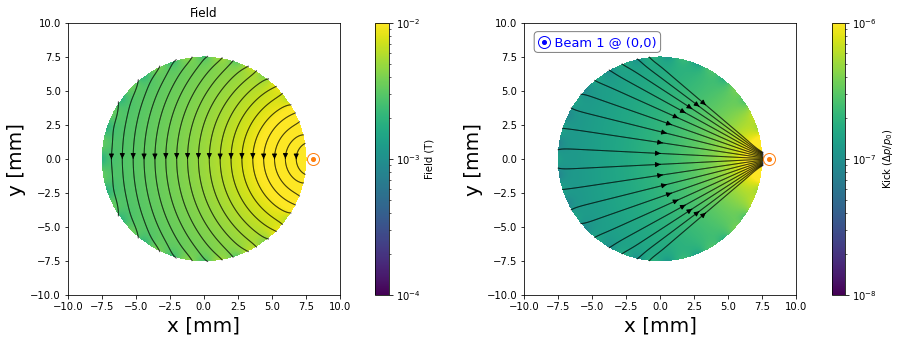

In [3]:


p0c = 7000e9
rightWire = wire(x=8e-3,y=0e-3,I=200,L=1)

xVec = np.linspace(-10e-3,10e-3,1000)
xObs,yObs = np.meshgrid(xVec,xVec)

Bx,By = 0*xObs,0*xObs
for thisWire in [rightWire]:
    _Bx,_By = rightWire.getField(xObs,yObs,order=20)
    Bx += _Bx
    By += _By


fig,axes = plt.subplots(1,2,figsize=(15,5))
plt.sca(axes[0])
plt.title('Field')
plotVecField(xObs,yObs,Bx,By,scaling=1e3,colorLabel='Field (T)',mode='streamplot',rValid=0.95*rightWire.r0,seedAngle=rightWire.theta0,nSeeds=20,colorLim = [1e-4,1e-2],norm = 'log')
for thisWire in [rightWire]:
    thisWire.plotWireLocation(scaling=1e3)
plt.axis('square')
plt.xlabel('x [mm]',fontsize=20)
plt.ylabel('y [mm]',fontsize=20)


xVec = np.linspace(-10e-3,10e-3,1000)
xObs,yObs = np.meshgrid(xVec,xVec)
Px,Py = 0*xObs,0*xObs

for thisWire in [rightWire]:
    _Px,_Py = thisWire.getKick(xObs,yObs,p0c,order=20)
    Px += _Px
    Py += _Py

    
plt.sca(axes[1])
plotVecField(xObs,yObs,Px,Py,scaling=1e3,colorLabel=r'Kick ($\Delta p/p_0$)',mode='streamplot',rValid=0.95*rightWire.r0,seedAngle=np.pi/2,nSeeds=20,colorLim = [1e-8,1e-6],norm='log')
for thisWire in [rightWire]:
    thisWire.plotWireLocation(scaling=1e3)

plotBeamDirection(0.05,0.93,name= 'Beam 1 @ (0,0)',color = 'b',direction = '+',fontsize = 13,ax = None)
plt.axis('square')
plt.xlabel('x [mm]',fontsize=20)
plt.ylabel('y [mm]',fontsize=20)


# Multipole element

In [92]:

# Initialise madx
madDict = { 'L' : 1,
            'Energy' : 7000,
            'Emittance_n' : 2.5e-6}

mad = Madx(command_log = "tmp_my_log.madlog")
mad.option(echo = True, warn = True)
mad.input(madSetup.format(**madDict))

# Create wire as multipole
firstWire = makeMadWire(name = 'multipole_wire',
                        I = 200,
                        L = 0.3,
                        pos = [8e-3,0],
                        nmax=20,
                        at = 1,
                        p0c = madDict['Energy']*1e9)



# Install in the sequence:
# FULL WIRE:
toInstall = firstWire

# Multipole only:
#toInstall = firstWire[:1]

# Kicker only:
#toInstall = firstWire[1:]


display(toInstall)
mad.input(seqedit(sequence = 'singlekick',editing = toInstall))

mad.input('survey,sequence=singleKick;')
mad.input('twiss,betx=1,bety=1,alfx=0,alfy=0;')
survey = mad.table['survey'].dframe()
twiss = mad.table['twiss'].dframe()

display(twiss)



mode                 name  at  \
0  install  multipole_wire_1of2   1   
1  install  multipole_wire_2of2   1   

                                          definition  
0  class_multipole_wire_1of2 : MULTIPOLE,KNL = {0...  
1  class_multipole_wire_2of2 : KICKER, L=0, HKICK...

name    keyword    s  betx      alfx  \
#s                      singlekick$start:1     marker  0.0   1.0  0.000000   
drift_0[0]                       drift_0:0      drift  1.0   2.0 -1.000000   
multipole_wire_2of2  multipole_wire_2of2:1     kicker  1.0   2.0 -1.000000   
multipole_wire_1of2  multipole_wire_1of2:1  multipole  1.0   2.0 -1.000016   
#e                        singlekick$end:1     marker  1.0   2.0 -1.000016   

                       mux  bety      alfy    muy    x  ...  sig54  sig55  \
#s                   0.000   1.0  0.000000  0.000  0.0  ...    0.0    0.0   
drift_0[0]           0.125   2.0 -1.000000  0.125  0.0  ...    0.0    0.0   
multipole_wire_2of2  0.125   2.0 -1.000000  0.125  0.0  ...    0.0    0.0   
multipole_wire_1of2  0.125   2.0 -0.999984  0.125  0.0  ...    0.0    0.0   
#e                   0.125   2.0 -0.999984  0.125  0.0  ...    0.0    0.0   

                     sig56  sig61  sig62  sig63  sig64  sig65  sig66   n1  
#s                     0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0  
drift_0[0]             0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0  
multipole_wire_2of2    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0  
multipole_wire_1of2    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0  
#e                     0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0  

[5 rows x 256 columns]

# MAD-X Tracking

In [93]:

x,y = np.meshgrid(np.linspace(-5e-3,5e-3,20),np.linspace(-5e-3,5e-3,20))
x,y = x.flatten(),y.flatten()
coordinates = pd.DataFrame({'x':x,'y':y,'px':np.zeros(len(x)),'py':np.zeros(len(y))})


MADTrackParticles(mad,coordinates)

pyDisplay.clear_output()

tracked = mad.table['trackone'].dframe()


# Extracting Tracking results
x,y = np.array(tracked.groupby('turn').get_group(0)['x']),np.array(tracked.groupby('turn').get_group(0)['y'])
DPx = np.array(tracked.groupby('turn').get_group(1)['px'])-np.array(tracked.groupby('turn').get_group(0)['px'])
DPy = np.array(tracked.groupby('turn').get_group(1)['py'])-np.array(tracked.groupby('turn').get_group(0)['py'])

summaryTable = pd.DataFrame(pd.DataFrame({'Source':np.repeat('MADX',len(x)),'x':x,'y':y,'DPx':DPx,'DPy':DPy}))


# Plotting

3.4999206453812646e-08 1.7065058277899506e-07


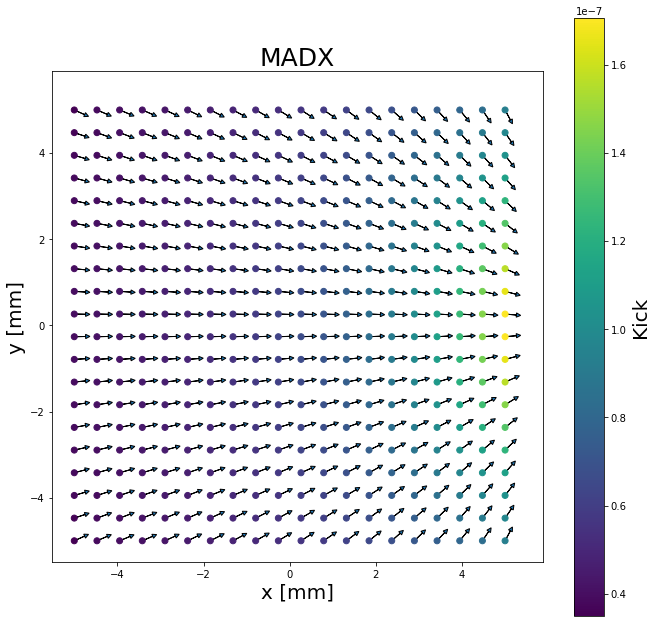

In [94]:
%matplotlib inline
grouped = summaryTable.groupby(['Source']).get_group

for source in ['MADX']:

    x,y,DPx,DPy = grouped(source)['x'],grouped(source)['y'],grouped(source)['DPx'],grouped(source)['DPy']

    plt.figure(figsize=(11,11))
    plt.title(source,fontsize=25)
    arrowLength = 0.5*np.max(np.diff(np.sort(x/1e-3)))

    for _x,_y,_DPx,_DPy in zip(x,y,DPx,DPy):
        thisNorm = vecNorm([ _DPx,_DPy])
        plt.arrow(_x/1e-3, _y/1e-3, _DPx/thisNorm*arrowLength, _DPy/thisNorm*arrowLength,head_width=0.1, head_length=0.1)

    plt.scatter(x/1e-3,y/1e-3,c=vecNorm([DPx,DPy]),zorder=len(x)+1)
    cbar = plt.colorbar()
    cbar.set_label('Kick',fontsize=20)
    plt.xlabel('x [mm]',fontsize=20)
    plt.ylabel('y [mm]',fontsize=20)
    plt.axis('square')
    
    print(np.min(vecNorm([DPx,DPy])),np.max(vecNorm([DPx,DPy])))

# Beam-Beam element

In [84]:
c = 299792458
LHC_C = 26659  
elec = 1.602176634e-19
m_p = 1.672621898e-27                           # Proton mass [kg]
m_p_eV = (m_p*c**2)/elec 


I_eff = 200
L = 0.3
# Initialise madx
madDict = { 'L' : 1,
            'Energy' : 7000,
            'Emittance_n' : 2.5e-6}

gamma_r = madDict['Energy']*1e9/m_p_eV + 1
beta_r = np.sqrt(1-1/gamma_r**2)
madDict['N_p'] = int(I_eff*LHC_C/(elec*c)/((1+beta_r**2)/beta_r))

mad = Madx(command_log = "tmp_my_log.madlog")
mad.option(echo = True, warn = True)
mad.input('option, bborbit=True')
mad.input(madSetup.format(**madDict))

# Use Wire element
# 

# FACTOR //2 comes from counter-rotation -> number of BB interaction over L meters is reduced by 2
BBWire = pd.DataFrame({'mode':['install'],
                             'name':['BBwire'],
                             'at': [1],
                             'definition':['class_BBwire : beambeam, '\
                                            f'charge = -{int(madDict["N_p"]/LHC_C*L)*2},'\
                                            'xma = 8e-3, yma = 0,'\
                                            'sigx = 200e-6, sigy = 200e-6,'\
                                            'width=0.1,'\
                                            'BBDIR = -1;']})



# Install in the sequence:
toInstall = BBWire
display(toInstall)
mad.input(seqedit(sequence = 'singlekick',editing = toInstall))

mad.input('survey,sequence=singleKick;')
mad.input('twiss,betx=1,bety=1,alfx=0,alfy=0;')
survey = mad.table['survey'].dframe()
twiss = mad.table['twiss'].dframe()

display(twiss)



mode    name  at                                         definition
0  install  BBwire   1  class_BBwire : beambeam, charge = -12491659962...

name   keyword    s  betx      alfx    mux  bety  \
#s          singlekick$start:1    marker  0.0   1.0  0.000000  0.000   1.0   
drift_0[0]           drift_0:0     drift  1.0   2.0 -1.000000  0.125   2.0   
bbwire                bbwire:1  beambeam  1.0   2.0 -1.000016  0.125   2.0   
#e            singlekick$end:1    marker  1.0   2.0 -1.000016  0.125   2.0   

                alfy    muy    x  ...  sig54  sig55  sig56  sig61  sig62  \
#s          0.000000  0.000  0.0  ...    0.0    0.0    0.0    0.0    0.0   
drift_0[0] -1.000000  0.125  0.0  ...    0.0    0.0    0.0    0.0    0.0   
bbwire     -0.999984  0.125  0.0  ...    0.0    0.0    0.0    0.0    0.0   
#e         -0.999984  0.125  0.0  ...    0.0    0.0    0.0    0.0    0.0   

            sig63  sig64  sig65  sig66   n1  
#s            0.0    0.0    0.0    0.0  0.0  
drift_0[0]    0.0    0.0    0.0    0.0  0.0  
bbwire        0.0    0.0    0.0    0.0  0.0  
#e            0.0    0.0    0.0    0.0  0.0  

[4 rows x 256 columns]

3.689801880800128e-08 1.7065466958455592e-07


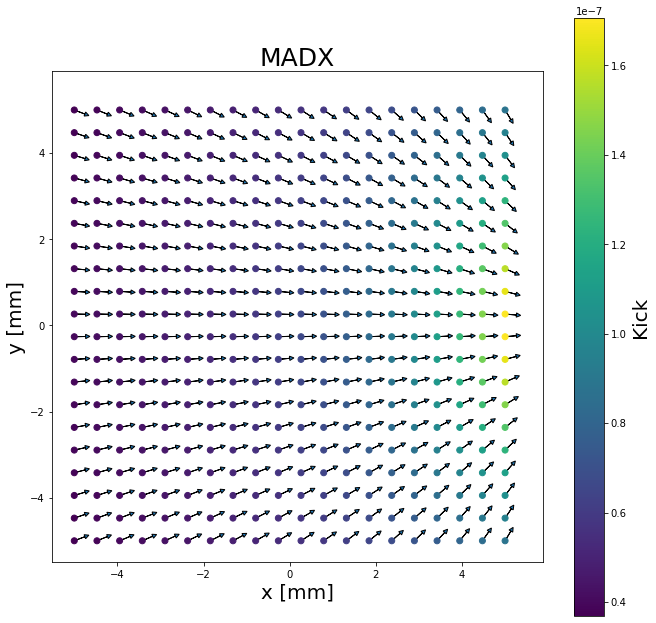

In [85]:

x,y = np.meshgrid(np.linspace(-5e-3,5e-3,20),np.linspace(-5e-3,5e-3,20))
x,y = x.flatten(),y.flatten()
coordinates = pd.DataFrame({'x':x,'y':y,'px':np.zeros(len(x)),'py':np.zeros(len(y))})


MADTrackParticles(mad,coordinates)

pyDisplay.clear_output()

tracked = mad.table['trackone'].dframe()


# Extracting Tracking results
x,y = np.array(tracked.groupby('turn').get_group(0)['x']),np.array(tracked.groupby('turn').get_group(0)['y'])
DPx = np.array(tracked.groupby('turn').get_group(1)['px'])-np.array(tracked.groupby('turn').get_group(0)['px'])
DPy = np.array(tracked.groupby('turn').get_group(1)['py'])-np.array(tracked.groupby('turn').get_group(0)['py'])

summaryTable = pd.DataFrame(pd.DataFrame({'Source':np.repeat('MADX',len(x)),'x':x,'y':y,'DPx':DPx,'DPy':DPy}))


%matplotlib inline
grouped = summaryTable.groupby(['Source']).get_group

for source in ['MADX']:

    x,y,DPx,DPy = grouped(source)['x'],grouped(source)['y'],grouped(source)['DPx'],grouped(source)['DPy']

    plt.figure(figsize=(11,11))
    plt.title(source,fontsize=25)
    arrowLength = 0.5*np.max(np.diff(np.sort(x/1e-3)))

    for _x,_y,_DPx,_DPy in zip(x,y,DPx,DPy):
        thisNorm = vecNorm([ _DPx,_DPy])
        plt.arrow(_x/1e-3, _y/1e-3, _DPx/thisNorm*arrowLength, _DPy/thisNorm*arrowLength,head_width=0.1, head_length=0.1)

    plt.scatter(x/1e-3,y/1e-3,c=vecNorm([DPx,DPy]),zorder=len(x)+1)
    cbar = plt.colorbar()
    cbar.set_label('Kick',fontsize=20)
    plt.xlabel('x [mm]',fontsize=20)
    plt.ylabel('y [mm]',fontsize=20)
    plt.axis('square')
    
    print(np.min(vecNorm([DPx,DPy])),np.max(vecNorm([DPx,DPy])))

# WIRE element from MAD-X

## Tobias Persson implementation

`label: WIRE,  CURRENT={real, ... }, L=real,L_INT={real, ... }, L_PHY={real,...};`


The $\texttt{WIRE}$ element allows to define one or several wire elements at once. 

- $\texttt{L}$ The length of the element in the sequence.
- $\texttt{CURRENT}$ The current for the wires. 
- $\texttt{L_PHY}$ This should correspond to the actuall physical length of the wires. 
- $\texttt{L_INT}$ The length where we stop integrating the effect of the field.
   It needs to be larger or the same as $\texttt{L_PHY}$.
- $\texttt{XMA}$ This specifies the horizontal offset of the wire compared to the reference orbit. 
- $\texttt{YMA}$ This specifies the vertical offset of the wire compared to the reference orbit. 


The WIRE as implemented in MAD-X is imlemented as a thin kick. However, it is still 
possible to define a length of the wire but internally the element is 
placed in the middle and drift spaces are placed on each side of the $\texttt{WIRE}$.
Note also that the collimator element has the same attiributes as the $\texttt{WIRE}$
and by defining it using the same parameters you can also get the collimator with a wire
inside. 


In [87]:

# Initialise madx
madDict = { 'L' : 1,
            'Energy' : 7000,
            'Emittance_n' : 2.5e-6}

mad = Madx(command_log = "tmp_my_log.madlog")
mad.option(echo = True, warn = True)
mad.input('option, bborbit=True')
mad.input(madSetup.format(**madDict))

# Use Wire element
# 
L = 0.3
secondWire = pd.DataFrame({'mode':['install'],
                             'name':['defaultWire'],
                             'at': [1],
                             'definition':[f'class_defaultWire : wire, current = 200, L = 0, L_phy = {L}, L_int = {L}, Xma = 8e-3, Yma = 0e-3;']})



# Install in the sequence:
toInstall = secondWire
display(toInstall)
mad.input(seqedit(sequence = 'singlekick',editing = toInstall,makeThin=True))

mad.input('survey,sequence=singleKick;')
mad.input('twiss,betx=1,bety=1,alfx=0,alfy=0;')
survey = mad.table['survey'].dframe()
twiss = mad.table['twiss'].dframe()

display(twiss)



mode         name  at                                         definition
0  install  defaultWire   1  class_defaultWire : wire, current = 200, L = 0...

name keyword    s  betx  alfx    mux  bety  alfy  \
#s           singlekick$start:1  marker  0.0   1.0   0.0  0.000   1.0   0.0   
drift_0[0]            drift_0:0   drift  1.0   2.0  -1.0  0.125   2.0  -1.0   
defaultwire       defaultwire:1    wire  1.0   2.0  -1.0  0.125   2.0  -1.0   
#e             singlekick$end:1  marker  1.0   2.0  -1.0  0.125   2.0  -1.0   

               muy    x  ...  sig54  sig55  sig56  sig61  sig62  sig63  sig64  \
#s           0.000  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
drift_0[0]   0.125  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
defaultwire  0.125  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
#e           0.125  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

             sig65  sig66   n1  
#s             0.0    0.0  0.0  
drift_0[0]     0.0    0.0  0.0  
defaultwire    0.0    0.0  0.0  
#e             0.0    0.0  0.0  

[4 rows x 256 columns]

In [88]:
x,y = np.meshgrid(np.linspace(-5e-3,5e-3,20),np.linspace(-5e-3,5e-3,20))
x,y = x.flatten(),y.flatten()
coordinates = pd.DataFrame({'x':x,'y':y,'px':np.zeros(len(x)),'py':np.zeros(len(y))})


MADTrackParticles(mad,coordinates,saveFile='trackingresults.trk')

useTrackone = False
if useTrackone:
    tracked = mad.table['trackone'].dframe()
    # Extracting Tracking results
    x,y = np.array(tracked.groupby('turn').get_group(0)['x']),np.array(tracked.groupby('turn').get_group(0)['y'])
    DPx = np.array(tracked.groupby('turn').get_group(1)['px'])-np.array(tracked.groupby('turn').get_group(0)['px'])
    DPy = np.array(tracked.groupby('turn').get_group(1)['py'])-np.array(tracked.groupby('turn').get_group(0)['py'])

    
# Plotting Resulting trajectories
pyDisplay.clear_output()

MADFile = 'tmp_my_log.madlog'
# Running with other MADX-Tobias 
subprocess.call('rm trackingresults.trk',shell=True)
subprocess.call(f'/afs/cern.ch/user/t/tpersson/public/for_Guido/madx_forGuido {MADFile}', shell=True,stdout=subprocess.DEVNULL,stderr=subprocess.STDOUT)

with open("trackingresults.trk", "r+") as f:
    content = f.readlines()
    f.seek(0)
    for line in content:
        if '#segment' not in line:
            f.write(line)
    f.truncate()
tracked = tfs.read("trackingresults.trk")
tracked.columns = tracked.columns.str.lower()

# Extracting Tracking results
x,y = np.array(tracked.groupby('turn').get_group(0)['x']),np.array(tracked.groupby('turn').get_group(0)['y'])
DPx = np.array(tracked.groupby('turn').get_group(1)['px'])-np.array(tracked.groupby('turn').get_group(0)['px'])
DPy = np.array(tracked.groupby('turn').get_group(1)['py'])-np.array(tracked.groupby('turn').get_group(0)['py'])




In [11]:
mad.table['trackone'].dframe()

number  turn         x   px      y   py    t   pt    s    e
#e     1.0   0.0 -0.005000  0.0 -0.005  0.0  0.0  0.0  0.0  0.0
#e     2.0   0.0 -0.004474  0.0 -0.005  0.0  0.0  0.0  0.0  0.0
#e     3.0   0.0 -0.003947  0.0 -0.005  0.0  0.0  0.0  0.0  0.0
#e     4.0   0.0 -0.003421  0.0 -0.005  0.0  0.0  0.0  0.0  0.0
#e     5.0   0.0 -0.002895  0.0 -0.005  0.0  0.0  0.0  0.0  0.0
..     ...   ...       ...  ...    ...  ...  ...  ...  ...  ...
#e   396.0   1.0  0.002895  0.0  0.005  0.0  0.0  0.0  1.0  0.0
#e   397.0   1.0  0.003421  0.0  0.005  0.0  0.0  0.0  1.0  0.0
#e   398.0   1.0  0.003947  0.0  0.005  0.0  0.0  0.0  1.0  0.0
#e   399.0   1.0  0.004474  0.0  0.005  0.0  0.0  0.0  1.0  0.0
#e   400.0   1.0  0.005000  0.0  0.005  0.0  0.0  0.0  1.0  0.0

[800 rows x 10 columns]

## Running on the special tpersson build:

## MAD-X tracking (wire element not recognized by XSuite)

3.522466590076913e-08 1.6895016993916387e-07


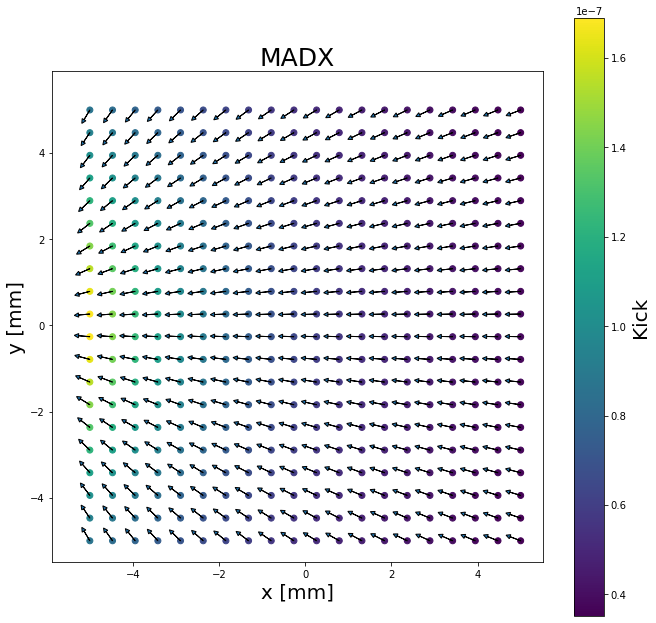

In [89]:

plt.figure(figsize=(11,11))
plt.title('MADX',fontsize=25)
arrowLength = 0.5*np.max(np.diff(np.sort(x/1e-3)))

for _x,_y,_DPx,_DPy in zip(x,y,DPx,DPy):
    thisNorm = vecNorm([ _DPx,_DPy])
    plt.arrow(_x/1e-3, _y/1e-3, _DPx/thisNorm*arrowLength, _DPy/thisNorm*arrowLength,head_width=0.1, head_length=0.1)

plt.scatter(x/1e-3,y/1e-3,c=vecNorm([DPx,DPy]),zorder=-1)
cbar = plt.colorbar()
cbar.set_label('Kick',fontsize=20)
plt.xlabel('x [mm]',fontsize=20)
plt.ylabel('y [mm]',fontsize=20)
plt.axis('square')

print(np.min(vecNorm([DPx,DPy])),np.max(vecNorm([DPx,DPy])))